In [1]:
# Scrape Twitter tweets with snscrape
import snscrape.modules.twitter as sntwitter

query = "bitcoin"
tweets = []
limit = 100

for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    if len(tweets) == limit:
        break
    else:
        if tweet.lang=='en':
            tweets.append(str(tweet.rawContent))

In [2]:
# Store the tweets in a dataframe
import pandas as pd

df = pd.DataFrame(tweets, columns=['Tweet'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [3]:
df.head()

,Tweet
0,@silkytommy We shall see…\nI’m sure you were s...
1,👇 5) Global Crypto trading #volume increased b...
2,RANDLEPERRIN found #bitcoin in a User vault at...
3,@RantinArkansan @phoenux2016 @Dylanwryter @Bow...
4,👇 4) The Global Crypto #market cap increased b...


In [4]:
# Set up the model environment
import torch, torchtext, torchdata
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torchtext.datasets import SST2
train = SST2(split='train')

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train),
                                  specials=['<unk>','<pad>','<bos>','<eos>'])

vocab.set_default_index(vocab['<unk>'])

text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

pad_idx = vocab['<pad>']

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300
output_dim = 2
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)

In [5]:
# Load the pretrained LSTM model
save_path = f'models/{model.__class__.__name__}_SST2.pt'

model.load_state_dict(torch.load(save_path, map_location=torch.device(device)))

<All keys matched successfully>

In [6]:
# Classify the sentiments of the tweets
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

sentiments = []

for tweet in tweets:
    tweet = torch.tensor(text_pipeline(tweet))
    tweet = tweet.reshape(1, -1)
    tweet_length = torch.tensor([tweet.size(1)]).to(dtype=torch.int64)
    prediction = int(predict(tweet, tweet_length))
    sentiments.append(prediction)

In [7]:
# Store the sentiments in the dataframe
df['Sentiment'] = sentiments

In [8]:
df.head()

,Tweet,Sentiment
0,@silkytommy We shall see…\nI’m sure you were s...,0
1,👇 5) Global Crypto trading #volume increased b...,0
2,RANDLEPERRIN found #bitcoin in a User vault at...,0
3,@RantinArkansan @phoenux2016 @Dylanwryter @Bow...,0
4,👇 4) The Global Crypto #market cap increased b...,0


In [9]:
# Count positives (1) and negatives (0)
df.Sentiment.value_counts()

0    84
1    16
Name: Sentiment, dtype: int64

<BarContainer object of 2 artists>

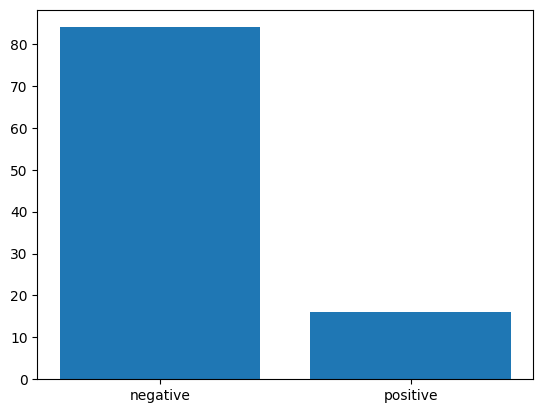

In [10]:
# Plot positives and negatives
import matplotlib.pyplot as plt

negative = df[df.Sentiment == 0]
positive = df[df.Sentiment == 1]

labels = ['negative', 'positive']
counts = [len(negative), len(positive)]

plt.bar(labels, counts)

In [11]:
# Tokenize the tweets
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def preprocessing(sentence):

    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []

    for token in doc:
        if token.text.lower() not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
                token.pos_ != 'SYM' and token.text not in list('0123456789+-*^~%$#@&/\|[]<>(){}') and \
                token.text.startswith('@') == False:
            cleaned_tokens.append(token.lemma_.lower().strip())

    return " ".join(cleaned_tokens)

df['Tokens'] = df['Tweet'].apply(preprocessing)

df.head()

,Tweet,Sentiment,Tokens
0,@silkytommy We shall see…\nI’m sure you were s...,0,shall sure shock bitcoin football play spotify...
1,👇 5) Global Crypto trading #volume increased b...,0,👇 global crypto trading volume increase 17.8 w...
2,RANDLEPERRIN found #bitcoin in a User vault at...,0,randleperrin find bitcoin user vault location ...
3,@RantinArkansan @phoenux2016 @Dylanwryter @Bow...,0,"100,000 random american citizen die mean ukrai..."
4,👇 4) The Global Crypto #market cap increased b...,0,👇 global crypto market cap increase +10.9 wow ...


In [12]:
# Create positive and negative vocabulary
pos_corpus = [sent.split(" ") for sent in df.Tokens[df.Sentiment == 1].to_numpy()]
neg_corpus = [sent.split(" ") for sent in df.Tokens[df.Sentiment == 0].to_numpy()]

pos_vocab = []
for i in range(len(pos_corpus)):
    for word in pos_corpus[i]:
        pos_vocab.append(word)

neg_vocab = []
for i in range(len(neg_corpus)):
    for word in neg_corpus[i]:
        neg_vocab.append(word)

len(pos_vocab), len(neg_vocab)

(180, 951)

In [13]:
# Find top words for the positives and negatives
from collections import Counter

top_pos_words = []
for i in range(10):
    pos_word = Counter(pos_vocab).most_common(10)[i][0]
    top_pos_words.append(pos_word)

top_neg_words = []
for i in range(10):
    neg_word = Counter(neg_vocab).most_common(10)[i][0]
    top_neg_words.append(neg_word)

print("Top positive words")
print("******************")
print(top_pos_words)
print("Top negative words")
print("******************")
print(top_neg_words)

Top positive words
******************
['bitcoin', 'price', 'ma', '-&gt', 'bullish', 'experience', '👇', 'ethereum', 'trend', 'eth']
Top negative words
******************
['bitcoin', 'btc', 'crypto', 'nft', 'price', 'free', 'sat', 'amp', 'claim', 'lightning']
